# **Mithila ART CLASSIFICATION MODEL**

## Install Necessary Dependencies

In [1]:
# !pip install tensorflow keras numpy matplotlib scikit-learn opencv-python
# !pip install pillow

In [2]:
import os
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dropout, Dense, GlobalMaxPooling2D
import datetime




In [3]:
def split_data(source_dir, dest_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    # Validate ratios
    if train_ratio + val_ratio + test_ratio != 1.0:
        raise ValueError("Train, validation, and test ratios must sum to 1.")
    
    # Create destination folders
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(dest_dir, split)
        os.makedirs(split_path, exist_ok=True)
    
    # Iterate over each class folder
    for class_name in os.listdir(source_dir):
        class_path = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        # Get all files in the class folder
        files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
        
        # Split files into train, validation, and test sets
        train_files, temp_files = train_test_split(files, test_size=(1 - train_ratio), random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)
        
        # Copy files to destination directories
        for split, split_files in zip(['train', 'val', 'test'], [train_files, val_files, test_files]):
            split_class_dir = os.path.join(dest_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
            for file in split_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(split_class_dir, file))
    
    print("Data successfully split into train, validation, and test sets.")

# Example usage:
source_directory = "C:\\Users\PC\\Downloads\\folk-art-dataset-main"
destination_directory = "./dataset"

# split_data(source_directory, destination_directory)


In [4]:
def convert_images_to_jpg(dataset_dir):
    # Supported extensions for conversion
    supported_extensions = ['.jpeg', '.png', '.gif']
    
    # Traverse through the dataset directory
    for root, _, files in os.walk(dataset_dir):
        for file in files:
            file_path = os.path.join(root, file)
            file_name, file_ext = os.path.splitext(file)

            # Check if file has a supported extension
            if file_ext.lower() in supported_extensions:
                try:
                    # Open the image
                    img = Image.open(file_path).convert('RGB')
                    
                    # New file path with the same directory but `.jpg` extension
                    new_file_path = os.path.join(root, f"{file_name}.jpg")
                    
                    # Save the image as `.jpg`
                    img.save(new_file_path, 'JPEG')
                    
                    # Delete the original file
                    os.remove(file_path)
                    
                    print(f"Converted and replaced: {file_path} -> {new_file_path}")
                except Exception as e:
                    print(f"Error converting {file_path}: {e}")

# Example usage
dataset_directory = "./dataset"
# convert_images_to_jpg(dataset_directory)


In [5]:
img_size = (128, 128)
batch_size = 8

In [6]:
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of height
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Apply random zooming
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in pixels for rotations/shifts with nearest value
)

train_generator = train_datagen.flow_from_directory(
    'dataset/train',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 21151 images belonging to 30 classes.


In [7]:
print("Class Indices:", train_generator.class_indices)

Class Indices: {'Aipan Art (Uttarakhand)': 0, 'Assamese Miniature Painting (Assam)': 1, 'Basholi Painting (Jammu and Kashmir)': 2, 'Bhil Painting (Madhya Pradesh)': 3, 'Chamba Rumal (Himachal Pradesh)': 4, 'Cheriyal Scroll Painting (Telangana)': 5, 'Dokra Art(West Bengal)': 6, 'Gond Painting (Madhya Pradesh)': 7, 'Kalamkari Painting (Andra Pradesh and Telangana)': 8, 'Kalighat Painting (West Bengal)': 9, 'Kangra Painting (Himachal Pradesh)': 10, 'Kerala Mural Painting (Kerala)': 11, 'Kondapalli Bommallu (Andra Pradesh)': 12, 'Kutch Lippan Art (Gujarat)': 13, 'Leather Puppet Art (Andra Pradesh)': 14, 'Madhubani Painting (Bihar)': 15, 'Mandala Art': 16, 'Mandana Art (Rajasthan)': 17, 'Mata Ni Pachedi (Gujarat)': 18, 'Meenakari Painting (Rajasthan)': 19, 'Mughal Paintings': 20, 'Mysore Ganjifa Art (Karnataka)': 21, 'Pattachitra Painting (Odisha and Bengal)': 22, 'Patua Painting (West Bengal)': 23, 'Pichwai Painting (Rajasthan)': 24, 'Rajasthani Miniature Painting (Rajasthan)': 25, 'Rogan 

In [8]:
test_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of height
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Apply random zooming
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in pixels for rotations/shifts with nearest value
)
test_generator = test_datagen.flow_from_directory(
    'dataset/test',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4522 images belonging to 30 classes.


In [9]:
print("Class Indices:", test_generator.class_indices)

Class Indices: {'Aipan Art (Uttarakhand)': 0, 'Assamese Miniature Painting (Assam)': 1, 'Basholi Painting (Jammu and Kashmir)': 2, 'Bhil Painting (Madhya Pradesh)': 3, 'Chamba Rumal (Himachal Pradesh)': 4, 'Cheriyal Scroll Painting (Telangana)': 5, 'Dokra Art(West Bengal)': 6, 'Gond Painting (Madhya Pradesh)': 7, 'Kalamkari Painting (Andra Pradesh and Telangana)': 8, 'Kalighat Painting (West Bengal)': 9, 'Kangra Painting (Himachal Pradesh)': 10, 'Kerala Mural Painting (Kerala)': 11, 'Kondapalli Bommallu (Andra Pradesh)': 12, 'Kutch Lippan Art (Gujarat)': 13, 'Leather Puppet Art (Andra Pradesh)': 14, 'Madhubani Painting (Bihar)': 15, 'Mandala Art': 16, 'Mandana Art (Rajasthan)': 17, 'Mata Ni Pachedi (Gujarat)': 18, 'Meenakari Painting (Rajasthan)': 19, 'Mughal Paintings': 20, 'Mysore Ganjifa Art (Karnataka)': 21, 'Pattachitra Painting (Odisha and Bengal)': 22, 'Patua Painting (West Bengal)': 23, 'Pichwai Painting (Rajasthan)': 24, 'Rajasthani Miniature Painting (Rajasthan)': 25, 'Rogan 

In [10]:
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20% of width
    height_shift_range=0.2,  # Randomly shift images vertically by 20% of height
    shear_range=0.2,  # Apply random shearing transformations
    zoom_range=0.2,  # Apply random zooming
    horizontal_flip=True,  # Randomly flip images horizontally
    fill_mode='nearest'  # Fill in pixels for rotations/shifts with nearest value
)
val_generator = val_datagen.flow_from_directory(
    'dataset/val',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 4543 images belonging to 30 classes.


In [11]:
print("Class Indices:", val_generator.class_indices)

Class Indices: {'Aipan Art (Uttarakhand)': 0, 'Assamese Miniature Painting (Assam)': 1, 'Basholi Painting (Jammu and Kashmir)': 2, 'Bhil Painting (Madhya Pradesh)': 3, 'Chamba Rumal (Himachal Pradesh)': 4, 'Cheriyal Scroll Painting (Telangana)': 5, 'Dokra Art(West Bengal)': 6, 'Gond Painting (Madhya Pradesh)': 7, 'Kalamkari Painting (Andra Pradesh and Telangana)': 8, 'Kalighat Painting (West Bengal)': 9, 'Kangra Painting (Himachal Pradesh)': 10, 'Kerala Mural Painting (Kerala)': 11, 'Kondapalli Bommallu (Andra Pradesh)': 12, 'Kutch Lippan Art (Gujarat)': 13, 'Leather Puppet Art (Andra Pradesh)': 14, 'Madhubani Painting (Bihar)': 15, 'Mandala Art': 16, 'Mandana Art (Rajasthan)': 17, 'Mata Ni Pachedi (Gujarat)': 18, 'Meenakari Painting (Rajasthan)': 19, 'Mughal Paintings': 20, 'Mysore Ganjifa Art (Karnataka)': 21, 'Pattachitra Painting (Odisha and Bengal)': 22, 'Patua Painting (West Bengal)': 23, 'Pichwai Painting (Rajasthan)': 24, 'Rajasthani Miniature Painting (Rajasthan)': 25, 'Rogan 

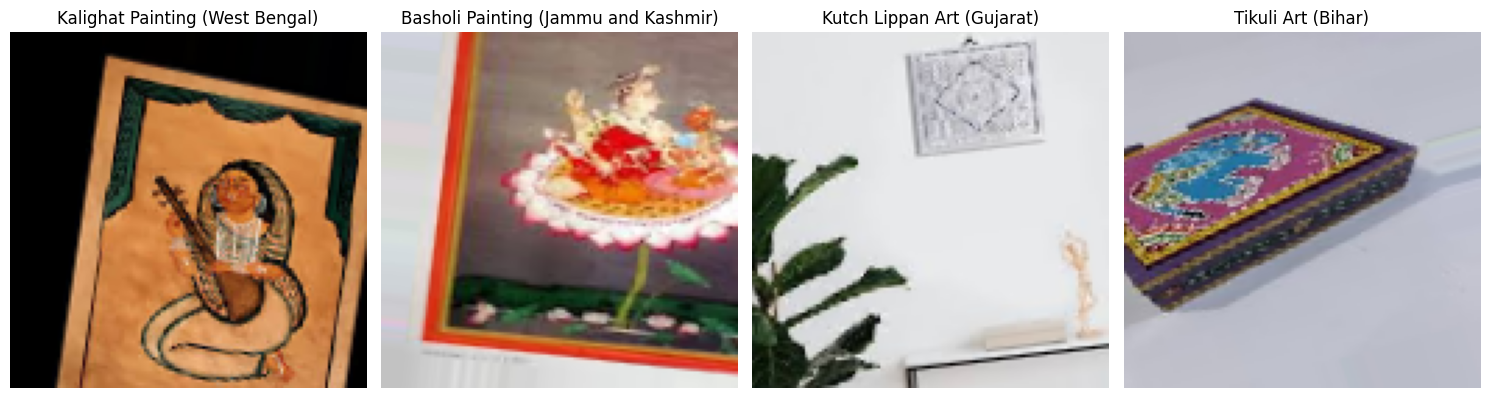

In [58]:

images, labels = next(train_generator)  # Fetches the next batch

num_images = 4
plt.figure(figsize=(15, 10))  # Create a larger figure for better visualization

for index in range(num_images):
    plt.subplot(1, num_images, index + 1)  # Create a subplot for each image
    plt.imshow(images[index])  # Display the image
    class_label = labels[index].argmax()  # Get the class index from one-hot encoding
    class_name = list(train_generator.class_indices.keys())[class_label]  # Get class name
    plt.title(class_name)  # Set the title to the class name
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()



In [59]:
def build_model():
    # Input layer
    input_layer = Input(shape=(128, 128, 3))

    # Load VGG16 pretrained model without the top layers
    vgg = VGG16(weights='imagenet', include_top=False)(input_layer)

    # Global max pooling layer to reduce spatial dimensions
    f1 = GlobalMaxPooling2D()(vgg)

    regress2 = Dense(128, activation='relu')(f1)
    dropout2 = Dropout(0.5)(regress2)  # Add another dropout layer

    output_layer = Dense(30, activation='softmax')(dropout2)  # Output for 30 classes

    # Define the model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model


In [60]:
model = build_model()

In [61]:
# Freeze layers in VGG16 to retain pretrained weights
for layer in model.layers[1].layers:  # Access VGG16 layers
    layer.trainable = False  # Set layers to non-trainable


In [62]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Use a lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_max_pooling2d_1 (Gl  (None, 512)               0         
 obalMaxPooling2D)                                               
                                                                 
 dense_3 (Dense)             (None, 128)               65664     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 30)                3870      
                                                           

In [63]:
# Define the log directory
log_dir = os.path.join("logs", "fit", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create a TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


In [64]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[tensorboard_callback]
)

Epoch 1/5
  52/2644 [..............................] - ETA: 9:15 - loss: 4.0716 - accuracy: 0.0216

KeyboardInterrupt: 

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")


142/142 [==============================] - 31s 222ms/step - loss: 1.9191 - accuracy: 0.6577
Test Accuracy: 0.6576735973358154


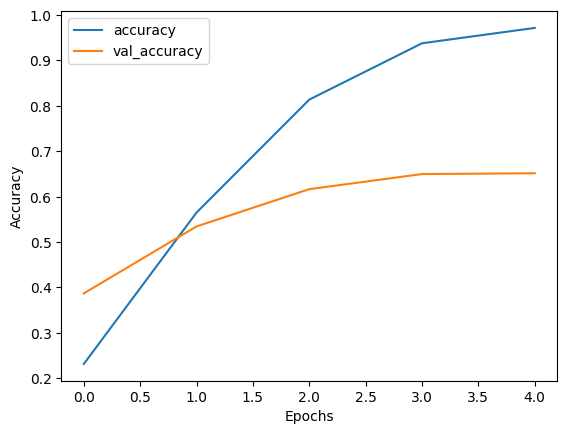

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

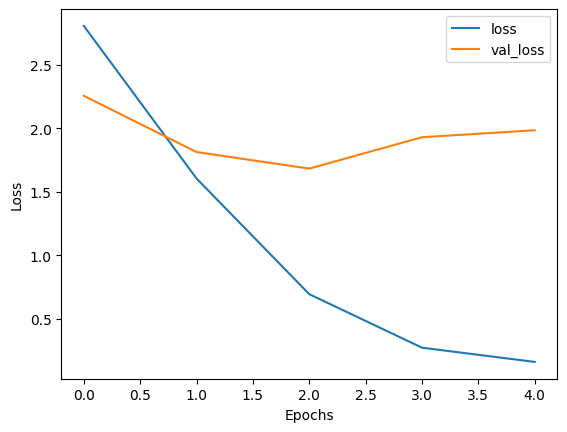

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()